# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [296]:
def fftnoise(f, just_phase=False):
    # adapted from frank-zalkow's Stack Overflow answer
    # https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
    assert len(f) % 2 == 0  # let's just work with even sample sizes for now
    Np = len(f) // 2

    # Power Spectrum -> Spectra
    f = np.array(np.sqrt(np.abs(f)), dtype="complex")

    # zero-mean condition (f(0) = sum of x(t) exp(0) -> must be zero)
    f[0] = 0.0 
        
    # Add random phase
    phases = np.exp(2j * np.pi * np.random.rand(Np))
    f[1:Np+1] *= phases

    # Add (gaussian) random amplitude
    if not just_phase:
        reals = np.random.randn(Np)
        ims = np.random.randn(Np)
        f[1:Np+1] *= (reals + 1j * ims) / np.sqrt(2)

    # Zeroth term must be real
    f[0] = f[0].real
    # Nyquist frequency must be real for even sample sizes
    f[Np] = np.real(f[Np])
    # Enforce evenness
    f[-1:-Np:-1] = np.conj(f[1:Np])

    return(np.real(np.fft.ifft(f, norm="ortho")))

In [297]:
def lorentzian(f, std, f0, y):
    return (std * y)**2 / ((f - f0)**2 + y**2)

def pink(f, std, rolloff=0):
    f1 = np.abs(f)
    indx1 = np.where(f1 <= rolloff)
    indx2 = np.where(f1 > rolloff)
    f1[indx1] = std**2
    f1[indx2] = std**2 * min(f1[indx2]) / (f1[indx2])
    return f1

def brown(f, std, rolloff=0):
    f1 = np.abs(f)
    indx1 = np.where(f1 <= rolloff)
    indx2 = np.where(f1 > rolloff)
    f1[indx1] = std**2
    print(min(f1[indx2]))
    f1[indx2] = (std * min(f1[indx2]))**2 / (f1[indx2]**2)
    return f1

def prune(array, min_value, max_value):
    idxlow = np.where(array < min_value)[0]
    idxhigh = np.where(array > max_value)[0]
    array[idxhigh] = max_value
    array[idxlow] = min_value
    return array

In [298]:
def generate_lorentzian_noise(s0, f0, y, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)
    f = lorentzian(freqs, s0, f0, y)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_pink_noise(s0, rolloff=0, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)
    f = pink(freqs, s0, rolloff=rolloff)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_brown_noise(s0, rolloff=0, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)
    f = brown(freqs, s0, rolloff=rolloff)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_white_noise(s0, min_value=-1e10, max_value=1e10, min_freq=-1e-10, max_freq=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)
    f = np.zeros(int(samples))
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = (s0 / 2)**2  # because zero-mean
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

# Lorentzian

## Randomness just on the phase

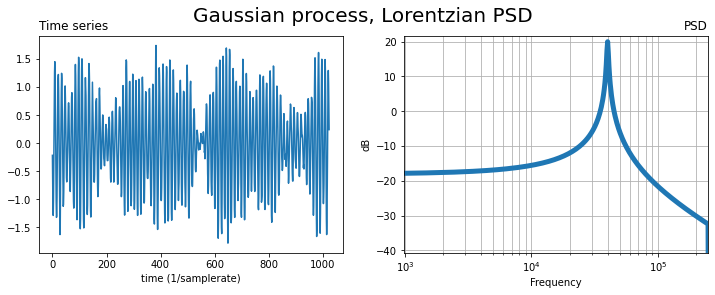

0.7918945585867805
9.969621413492437


In [299]:
std = 10
f0 = 4e4
gamma = 5e2
freqs, f, b = generate_lorentzian_noise(std, f0, gamma, just_phase=True)
freqs = freqs[1:]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho")[1:])**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5)
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
plt.suptitle("Gaussian process, Lorentzian PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

## Randomness on phase and amplitude of Fourier components

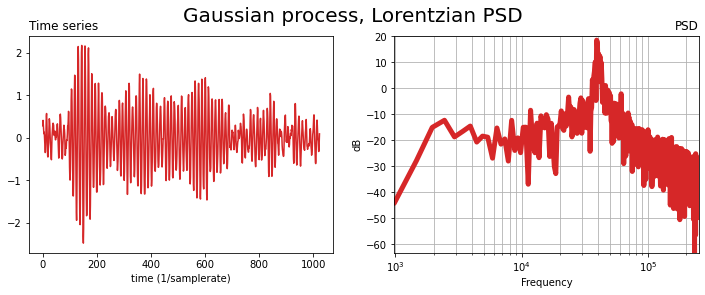

0.6758858187943803
8.439353656833923


In [300]:
std = 10
f0 = 4e4
gamma = 5e2
freqs, f, b = generate_lorentzian_noise(std, f0, gamma, just_phase=False)
freqs = freqs[1:]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho")[1:])**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5, color="C3")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
plt.suptitle("Gaussian process, Lorentzian PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

# Pink

## Randomness just on the phase

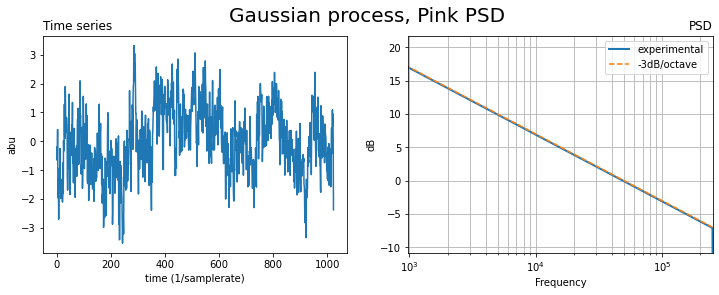

1.153711332819444
10.0


In [301]:
std = 10
samples = 1024
rolloff = 0
freqs, f, b = generate_pink_noise(std, rolloff=rolloff, samples=samples, just_phase=True)
freqs = freqs[1:]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(np.arange(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_ylabel("abu")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.fft(b, norm="ortho")[1:(len(b)//2+1)])**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=2, label="experimental")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500 / (freqs + 1)), ls="dashed", label="-3dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].legend()
plt.suptitle("Gaussian process, Pink PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

## Randomness on phase and amplitude of Fourier components

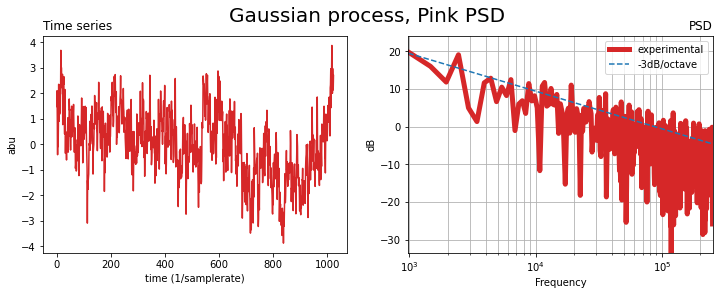

1.2906901979807808
13.156242778196987


In [302]:
std = 10
samples = 1024
rolloff = 0
freqs, f, b = generate_pink_noise(std, rolloff=rolloff, samples=samples, just_phase=False)
freqs = freqs[1:]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(np.arange(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_ylabel("abu")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho")[1:])**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5, label="experimental", color="C3")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500 / (freqs + 1)), ls="dashed", label="-3dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].legend()
plt.suptitle("Gaussian process, Pink PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

# White

## Randomness just on the phase

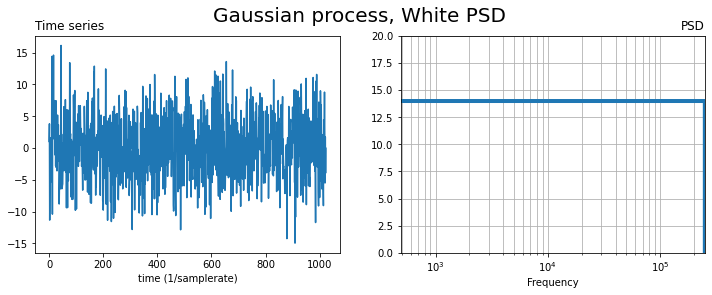

4.995114800983057
5.0000000000000036


In [303]:
std = 10
samples = 1024
freqs, f, b = generate_white_noise(std, samples=samples, just_phase=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4)
ax[1].set_ylim(0, 20)
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True, which="both")
plt.suptitle("Gaussian process, White PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

## Randomness on phase and amplitude of Fourier components

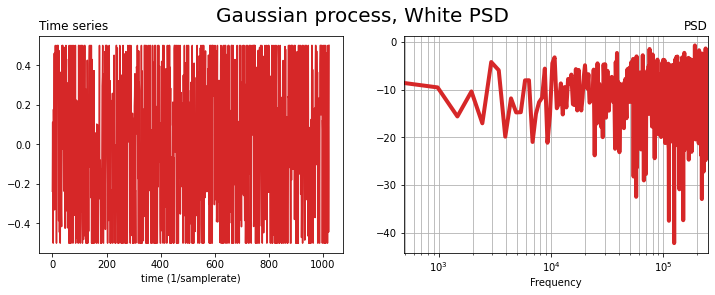

0.35882072553740585
0.9214235726778428


In [304]:
std = 1
samples = 1024
freqs, f, b = generate_white_noise(std,
                                   samplerate=1/2e-6,
                                   min_value=-0.5, max_value=0.5,
                                   samples=samples, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, color="C3")
# ax[1].set_ylim(0, 20)
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True, which="both")
plt.suptitle("Gaussian process, White PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

# Brown

## Randomness just on the phase

488.28125


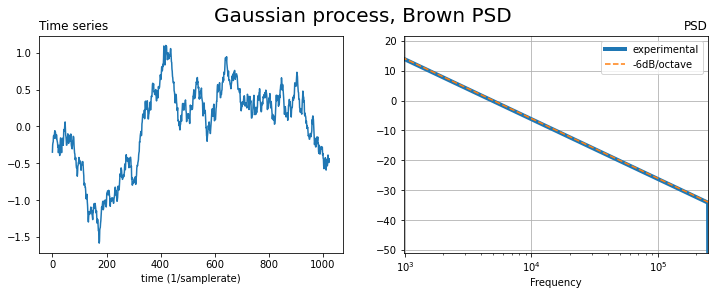

0.5664753747490444
10.0


In [290]:
std = 10
rolloff = 0
freqs, f, b = generate_brown_noise(std, rolloff=rolloff, samples=1024, just_phase=True)
freqs = freqs[1:]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho")[1:])**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, label="experimental")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500**2 / (freqs**2 + 1)), ls="dashed", label="-6dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True)
ax[1].legend()
plt.suptitle("Gaussian process, Brown PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

## Randomness on phase and amplitude of Fourier components

488.28125


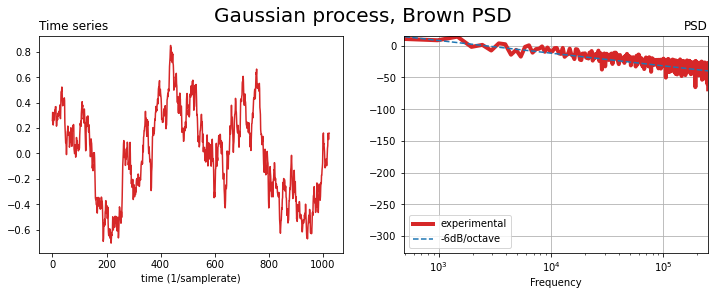

0.34544449976075536
5.142542583818104


In [295]:
std = 10
rolloff = 0
freqs, f, b = generate_brown_noise(std, rolloff=rolloff, samples=1024, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, label="experimental", color="C3")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500**2 / (freqs**2 + 1)), ls="dashed", label="-6dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True)
ax[1].legend()
plt.suptitle("Gaussian process, Brown PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

In [2442]:
print("{:e}".format(1/(2 * np.pi * np.sqrt(12e-12 * 10e-9))))

4.594407e+08


In [2532]:
print("{:e}".format(
    1 / (2 * np.pi * np.sqrt(0.1e-12 * 1e-3))
))
      

1.591549e+07


In [2508]:
ω = 30.1e6
L = 600e-9
C = 22e-12

In [2509]:
1/ (ω**2 * C)

5.01700262188557e-05

In [2522]:
Z = 1 / (2 * np.pi * 28e6 * 20e-12); Z

284.20525552124167

3558812.7170858853